# GER40 Market Data Curation
Analysis of 1-minute GER40 market data to identify gaps, statistics, and trading schedules

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## Load Data

In [5]:
df = pd.read_csv('/home/morteza/mkh/RLTrainer/raw-data/NETH25i_h1_20230101_0000_to_20251011_1200.csv')
df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time').reset_index(drop=True)
print(f"Total records: {len(df):,}")
print(f"Date range: {df['Time'].min()} to {df['Time'].max()}")
df.head()

Total records: 582,667
Date range: 2023-01-02 07:00:00+00:00 to 2025-10-10 19:59:00+00:00


,Time,OpenBid,OpenAsk,HighBid,HighAsk,LowBid,LowAsk,CloseBid,CloseAsk
0,2023-01-02 07:00:00+00:00,690.92,691.17,691.02,691.92,690.87,691.17,691.02,691.72
1,2023-01-02 07:01:00+00:00,691.02,691.87,692.12,692.77,691.02,691.82,691.87,692.72
2,2023-01-02 07:02:00+00:00,691.92,692.72,692.87,693.27,691.92,692.72,692.72,693.12
3,2023-01-02 07:03:00+00:00,692.72,693.27,693.37,693.97,692.72,693.22,692.97,693.52
4,2023-01-02 07:04:00+00:00,693.07,693.52,693.07,693.52,692.97,693.37,692.97,693.47


## Basic Statistics

In [6]:
print("Data shape:", df.shape)
print("\nColumn types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\nPrice statistics (CloseBid):")
print(df['CloseBid'].describe())

Data shape: (582667, 9)

Column types:
Time        datetime64[ns, UTC]
OpenBid                 float64
OpenAsk                 float64
HighBid                 float64
HighAsk                 float64
LowBid                  float64
LowAsk                  float64
CloseBid                float64
CloseAsk                float64
dtype: object

Missing values:
Time        0
OpenBid     0
OpenAsk     0
HighBid     0
HighAsk     0
LowBid      0
LowAsk      0
CloseBid    0
CloseAsk    0
dtype: int64

Price statistics (CloseBid):
count    582667.000000
mean        843.466863
std          74.730878
min         691.020000
25%         761.860000
50%         875.690000
75%         909.680000
max         968.550000
Name: CloseBid, dtype: float64


## Time Gap Analysis

In [7]:
df['time_diff'] = df['Time'].diff()
print("Time differences between consecutive records:")
print(df['time_diff'].value_counts().head(20))
print(f"\nExpected 1-minute intervals: {(df['time_diff'] == timedelta(minutes=1)).sum():,}")
print(f"Gaps > 1 minute: {(df['time_diff'] > timedelta(minutes=1)).sum():,}")

Time differences between consecutive records:
time_diff
0 days 00:01:00    574912
0 days 00:02:00      5097
0 days 00:03:00      1085
0 days 10:01:00       559
0 days 00:04:00       333
0 days 00:05:00       188
2 days 10:01:00       132
0 days 00:06:00        91
0 days 00:07:00        54
0 days 00:08:00        36
0 days 00:10:00        26
0 days 00:09:00        20
0 days 00:11:00        17
0 days 00:13:00        15
0 days 00:12:00        12
0 days 00:14:00        10
0 days 00:16:00        10
0 days 00:15:00         9
0 days 00:18:00         6
0 days 00:17:00         5
Name: count, dtype: int64

Expected 1-minute intervals: 574,912
Gaps > 1 minute: 7,754


## Missing Data Periods

In [8]:
gaps = df[df['time_diff'] > timedelta(minutes=1)].copy()
gaps['gap_minutes'] = gaps['time_diff'].dt.total_seconds() / 60
print(f"Total gaps: {len(gaps)}")
print("\nLargest gaps:")
print(gaps[['Time', 'gap_minutes']].sort_values('gap_minutes', ascending=False).head(20))

Total gaps: 7754

Largest gaps:
                            Time  gap_minutes
481479 2025-04-22 06:00:00+00:00       6361.0
57083  2023-04-11 06:00:00+00:00       6361.0
206746 2023-12-27 07:00:00+00:00       6361.0
260789 2024-04-02 06:00:00+00:00       6301.0
68403  2023-05-02 06:00:00+00:00       4921.0
209157 2024-01-02 07:00:00+00:00       4921.0
416802 2024-12-27 07:00:00+00:00       3961.0
320723 2024-07-15 06:00:00+00:00       3690.0
353712 2024-09-09 06:00:00+00:00       3690.0
382750 2024-10-28 07:00:00+00:00       3541.0
174147 2023-10-30 07:00:00+00:00       3541.0
488128 2025-05-05 06:00:00+00:00       3481.0
198546 2023-12-11 07:00:00+00:00       3481.0
473964 2025-04-07 06:00:00+00:00       3481.0
478148 2025-04-14 06:00:00+00:00       3481.0
445177 2025-02-17 07:00:00+00:00       3481.0
453432 2025-03-03 07:00:00+00:00       3481.0
449242 2025-02-24 07:00:00+00:00       3481.0
457609 2025-03-10 07:00:00+00:00       3481.0
461662 2025-03-17 07:00:00+00:00       3481.0


## Daily Trading Schedule Analysis

In [9]:
df['date'] = df['Time'].dt.date
df['hour'] = df['Time'].dt.hour
df['minute'] = df['Time'].dt.minute
df['day_of_week'] = df['Time'].dt.day_name()
daily_counts = df.groupby('date').size()
print("Records per day statistics:")
print(daily_counts.describe())
print("\nSample of days with record counts:")
print(daily_counts.head(20))

Records per day statistics:
count    710.000000
mean     820.657746
std       38.832137
min      334.000000
25%      819.000000
50%      832.000000
75%      837.000000
max      840.000000
dtype: float64

Sample of days with record counts:
date
2023-01-02    707
2023-01-03    833
2023-01-04    839
2023-01-05    838
2023-01-06    838
2023-01-09    837
2023-01-10    837
2023-01-11    833
2023-01-12    837
2023-01-13    837
2023-01-16    711
2023-01-17    838
2023-01-18    837
2023-01-19    836
2023-01-20    838
2023-01-23    839
2023-01-24    835
2023-01-25    839
2023-01-26    838
2023-01-27    831
dtype: int64


## Day of Week Analysis

Records by day of week:
day_of_week
Tuesday      117872
Thursday     117542
Wednesday    117487
Friday       116867
Monday       112899
Name: count, dtype: int64


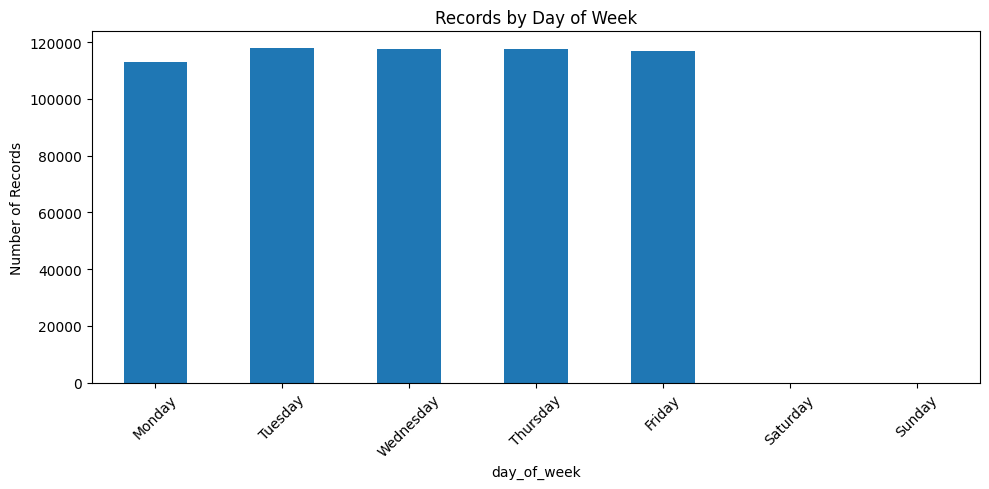

In [10]:
dow_counts = df['day_of_week'].value_counts()
print("Records by day of week:")
print(dow_counts)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_counts = dow_counts.reindex(days_order)
dow_counts.plot(kind='bar', title='Records by Day of Week', figsize=(10, 5))
plt.ylabel('Number of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Hourly Trading Patterns

Records by hour of day:
hour
6     25056
7     41991
8     42594
9     42589
10    42542
11    42592
12    42598
13    42475
14    42471
15    42464
16    41997
17    40294
18    39153
19    39553
20    14298
Name: count, dtype: int64


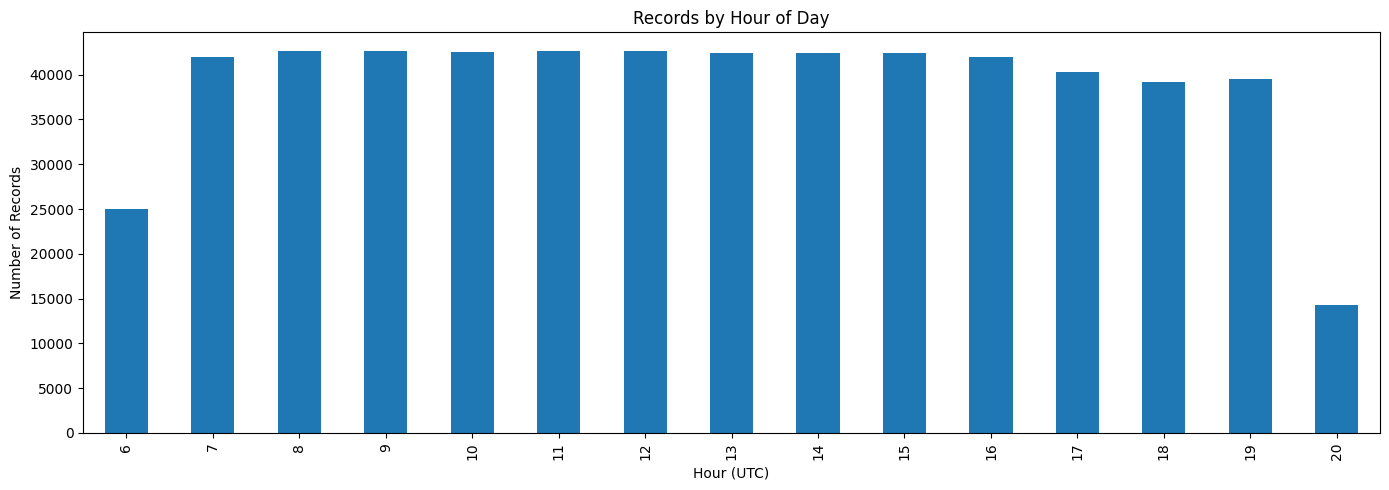

In [11]:
hourly_counts = df['hour'].value_counts().sort_index()
print("Records by hour of day:")
print(hourly_counts)
hourly_counts.plot(kind='bar', title='Records by Hour of Day', figsize=(14, 5))
plt.xlabel('Hour (UTC)')
plt.ylabel('Number of Records')
plt.tight_layout()
plt.show()

## First and Last Trading Times Each Day

In [12]:
daily_schedule = df.groupby('date')['Time'].agg(['min', 'max'])
daily_schedule['first_time'] = daily_schedule['min'].dt.time
daily_schedule['last_time'] = daily_schedule['max'].dt.time
daily_schedule['trading_hours'] = (daily_schedule['max'] - daily_schedule['min']).dt.total_seconds() / 3600
print("Sample daily schedules:")
print(daily_schedule.head(30))
print("\nMost common opening times:")
print(daily_schedule['first_time'].value_counts().head(10))
print("\nMost common closing times:")
print(daily_schedule['last_time'].value_counts().head(10))

Sample daily schedules:
                                 min                       max first_time  \
date                                                                        
2023-01-02 2023-01-02 07:00:00+00:00 2023-01-02 20:59:00+00:00   07:00:00   
2023-01-03 2023-01-03 07:00:00+00:00 2023-01-03 20:59:00+00:00   07:00:00   
2023-01-04 2023-01-04 07:00:00+00:00 2023-01-04 20:59:00+00:00   07:00:00   
2023-01-05 2023-01-05 07:00:00+00:00 2023-01-05 20:59:00+00:00   07:00:00   
2023-01-06 2023-01-06 07:00:00+00:00 2023-01-06 20:59:00+00:00   07:00:00   
2023-01-09 2023-01-09 07:00:00+00:00 2023-01-09 20:59:00+00:00   07:00:00   
2023-01-10 2023-01-10 07:00:00+00:00 2023-01-10 20:59:00+00:00   07:00:00   
2023-01-11 2023-01-11 07:00:00+00:00 2023-01-11 20:59:00+00:00   07:00:00   
2023-01-12 2023-01-12 07:00:00+00:00 2023-01-12 20:59:00+00:00   07:00:00   
2023-01-13 2023-01-13 07:00:00+00:00 2023-01-13 20:59:00+00:00   07:00:00   
2023-01-16 2023-01-16 07:00:00+00:00 2023-01-16 20:5

## Price Range and Volatility

Spread statistics:
count    582667.000000
mean          0.359794
std           0.144897
min           0.250000
25%           0.300000
50%           0.300000
75%           0.350000
max           2.700000
Name: spread, dtype: float64

Returns statistics:
count    5.826660e+05
mean     5.680124e-07
std      3.071783e-04
min     -3.285952e-02
25%     -1.296726e-04
50%      0.000000e+00
75%      1.321351e-04
max      1.380171e-02
Name: returns, dtype: float64


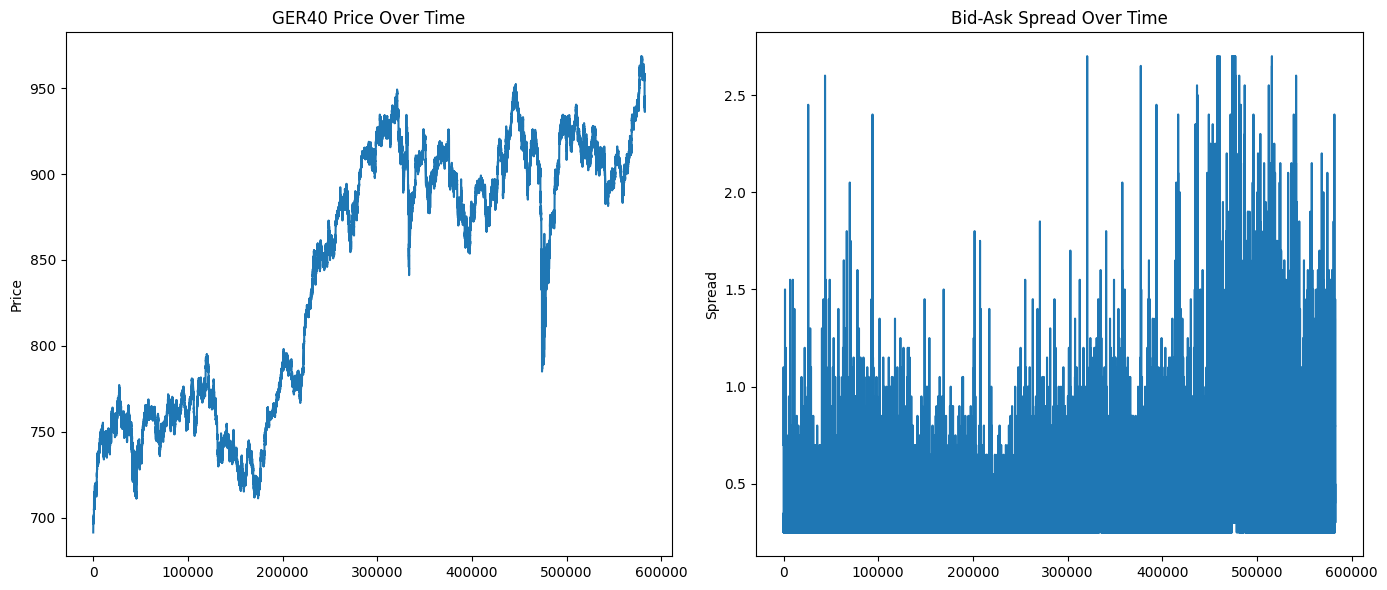

In [13]:
df['mid_price'] = (df['CloseBid'] + df['CloseAsk']) / 2
df['spread'] = df['CloseAsk'] - df['CloseBid']
df['returns'] = df['mid_price'].pct_change()
print("Spread statistics:")
print(df['spread'].describe())
print("\nReturns statistics:")
print(df['returns'].describe())
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
df['mid_price'].plot(title='GER40 Price Over Time')
plt.ylabel('Price')
plt.subplot(1, 2, 2)
df['spread'].plot(title='Bid-Ask Spread Over Time')
plt.ylabel('Spread')
plt.tight_layout()
plt.show()

## Data Completeness Check

In [14]:
start_time = df['Time'].min()
end_time = df['Time'].max()
expected_minutes = int((end_time - start_time).total_seconds() / 60) + 1
actual_records = len(df)
completeness = (actual_records / expected_minutes) * 100
print(f"Expected minutes (if continuous): {expected_minutes:,}")
print(f"Actual records: {actual_records:,}")
print(f"Data completeness: {completeness:.2f}%")
print(f"Missing records: {expected_minutes - actual_records:,}")

Expected minutes (if continuous): 1,458,060
Actual records: 582,667
Data completeness: 39.96%
Missing records: 875,393


## Summary Report

In [15]:
print("="*60)
print("GER40 DATA CURATION SUMMARY")
print("="*60)
print(f"\nData Period: {df['Time'].min()} to {df['Time'].max()}")
print(f"Total Records: {len(df):,}")
print(f"Data Completeness: {completeness:.2f}%")
print(f"\nTrading Days by Day of Week:")
trading_days = df.groupby(['date', 'day_of_week']).size().reset_index()[['date', 'day_of_week']]
print(trading_days['day_of_week'].value_counts().reindex(days_order))
print(f"\nTypical Trading Hours (UTC):")
print(f"  Most common open: {daily_schedule['first_time'].mode()[0]}")
print(f"  Most common close: {daily_schedule['last_time'].mode()[0]}")
print(f"\nPrice Range: {df['CloseBid'].min():.2f} - {df['CloseBid'].max():.2f}")
print(f"Average Spread: {df['spread'].mean():.2f}")
print(f"\nData Quality Issues:")
print(f"  Missing values: {df.isnull().sum().sum()}")
print(f"  Time gaps > 1 min: {(df['time_diff'] > timedelta(minutes=1)).sum():,}")
print("="*60)

GER40 DATA CURATION SUMMARY

Data Period: 2023-01-02 07:00:00+00:00 to 2025-10-10 19:59:00+00:00
Total Records: 582,667
Data Completeness: 39.96%

Trading Days by Day of Week:
day_of_week
Monday       139.0
Tuesday      144.0
Wednesday    142.0
Thursday     143.0
Friday       142.0
Saturday       NaN
Sunday         NaN
Name: count, dtype: float64

Typical Trading Hours (UTC):
  Most common open: 06:00:00
  Most common close: 19:59:00

Price Range: 691.02 - 968.55
Average Spread: 0.36

Data Quality Issues:
  Missing values: 2
  Time gaps > 1 min: 7,754
